In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.cross_validation import train_test_split

import seaborn as sns

%matplotlib inline

In [2]:
#import data
# export to csv
# run
# serialize results
# format results to df

# IMPORT MODELS

In [3]:
import GPy
from sklearn.svm import SVR, SVC
from sklearn.linear_model import Lasso

# IMPORT SCRIPTS

In [4]:
# CREATE INPUTS LIST
def get_array_percentiles(array):
		def percentile(x, array):
			return 100*np.mean(array <= x)

		return np.array(map(lambda x: percentile(x, array), array))

def get_percentiles(df):
	if isinstance(df, pd.DataFrame):
		new_df = df.copy()
		return new_df.apply(lambda x: get_array_percentiles(x), axis = 0)
	elif isinstance(df, np.ndarray):
		return np.apply_along_axis(get_percentiles, 0, a)
	else:
		print "TYPE ERROR; PLEASE INPUT pd.DataFrame OR np.ndarray"
		raise

In [5]:
def generate_inputs(X_name, X_input, output_columns, subset_columns, y_before_name, y_after_name, job_codes = None):
    """
    X_name: name of X_input
    X_input: raw input with O*NET-SOC Code
    output_columns: interest variable df, like automation, with O*NET-SOC Code
    subset_columns: output columns you want to subset X on. Str or List
    y_before: name of column containing before target
    y_after: name of column containing after target
    job_codes: necessary only if 
    """
    X = X_input.copy()
    # first, format inputs
    if job_codes and "O*NET-SOC Code" not in X_input.columns:
        X = pd.concat((X_input, job_codes), axis = 1)

    X = X.merge(output_columns, on = 'O*NET-SOC Code', how = 'inner')


    # generate X subsets
    print "CREATING X's"
    if isinstance(subset_columns, str):
        subset_columns = [subset_columns]

    subset_inputs = []
    subset_inputs.append(['full', X])
    for subset in subset_columns:
        Xss = X[subset]
        s = subset
        subset_inputs.append(['pos_change_' + s, X[Xss > 0]])
        subset_inputs.append(['neg_change_' + s, X[Xss < 0]])
        subset_inputs.append(['gt_mean_' + s, X[Xss > Xss.mean()]])
        subset_inputs.append(['lt_mean_' + s, X[Xss < Xss.mean()]])

    # generate transforms
    print "TRANFORMING X's"
    transformed_inputs = []
    cols = list(output_columns.columns)
    for subset_input in subset_inputs:
        transformed_inputs.append(subset_input)
        X_name, df = subset_input[0], subset_input[1]
        retain = df[cols]
        of_interest = df.drop(cols, axis = 1)

        # percentile
        pct_df = get_percentiles(of_interest)
        pct_df = pd.concat((pct_df, retain), axis = 1)
        pct_name = 'pile_' + X_name
        transformed_inputs.append([pct_name, pct_df])


        # log change
        if isinstance(of_interest, np.ndarray):
            minimum = np.min(of_interest)
        else:
            minimum = of_interest.values.min()
        if minimum > 0:
            log_df = np.log(of_interest)
            log_df = pd.concat((log_df, retain), axis = 1)
            log_name = 'log_' + X_name
            transformed_inputs.append([log_name, log_df])

    final_inputs = []
    
    # generate y inputs
    print "CREATING y's"
    for X in transformed_inputs:
        new_y_inputs = []
        X_name = X[0]
        y_before, y_after = X[1][y_before_name], X[1][y_after_name]
        delta = y_after - y_before
        pct_delta = (y_after.astype(float) - y_before.astype(float)) / y_before
        pile_pct_delta = get_array_percentiles(pct_delta)
        pctile_before = get_array_percentiles(y_before)
        pctile_after = get_array_percentiles(y_after)

        new_y_inputs.append(['before', y_before])
        new_y_inputs.append(['after', y_after])
        new_y_inputs.append(['pct_delta', pct_delta])
        new_y_inputs.append(['pile_pct_delta', pile_pct_delta])
        new_y_inputs.append(['pctile_before', pctile_before])
        new_y_inputs.append(['pctile_after', pctile_after])

        final_y_inputs = []
        for y_name, y_input in new_y_inputs:
            final_y_inputs.append([y_name, y_input])
            if min(y_input) > 0.0:
                final_y_inputs.append(['log_' + X_name, np.log(y_input)])

        X_final = X[1].drop(cols, axis = 1)
        for y_name, y_input_final in final_y_inputs:
            final_inputs.append([X_name, X_final, y_name, y_input_final])

    return final_inputs


def create_class_inputs(input_list):
    """
    Input list has to be structured as a list of lists, s.t. the inner list is constructed:

                [X_name, X, y_name, y]

    """
    class_list = []
    for i in input_list:
        X_name, X, y_name, y = i[0], i[1], i[2], i[3]

        # gt/lt than mean
        class_list.append([X_name, X, "gt_mean_" + y_name, y > np.mean(y)])
        class_list.append([X_name, X, "lt_mean_" + y_name, y < np.mean(y)])

        # gt/lt than 0
        if min(y) < 0 and max(y) > 0:
            class_list.append([X_name, X, "gt_0_" + y_name, y > 0])
            class_list.append([X_name, X, "lt_0_" + y_name, y < 0])

        # gt/lt Z std deviations from mean
        devs = np.array([0.5, 1, 1.5, 2, 2.5, 3])
        devs = np.hstack((devs, -devs))
        std = np.std(y)
        mean = np.mean(y)
        for sd in devs:
            new_y = y > (mean + sd*std)
            name = str(std) + "_gt_" + y_name
            class_list.append([X_name, X, name, new_y])

    return class_list

In [6]:
def score_model(y_pred, y_test, y_name, X_inputs, models, score_type):
    score = {}
    X_name, X = X_inputs[0], X_inputs[1]
    model_name, model = models[0], models[1]
    
    score['Model name'] = model_name
    score['Model'] = model
    score['X_name'] = X_name
    score['y_name'] = y_name
    score['y_pred'] = y_pred
    score['y_test'] = y_test
    
    try:
        likelihood = model.likelihood
    except:
        likelihood = 'N/A'

    if score_type == "classification":
        accuracy = -1
        precision = None
        recall = None
        specificity = None
        f1 = None
        ideal_cutoff = None

        chart_storage = np.array([None, None, None])
        for cutoff in np.arange(0, 1.001, 0.001):
            y_pred = y_pred > cutoff
            num_TP = float(np.sum((y_pred == 1) & (y_test == 1)))
            num_FP = float(np.sum((y_pred == 1) & (y_test == 0)))
            num_TN = float(np.sum((y_pred == 0) & (y_test == 0)))
            num_FN = float(np.sum((y_pred == 0) & (y_test == 1)))

            s_accuracy = np.mean(y_pred == y_test)
            s_precision = num_TP / (num_TP + num_FP)
            s_recall = num_TP / (num_TP + num_FN)
            s_specificity = num_TN / (num_TN + num_FP)
            s_f1 = (precision * recall) / (precision + recall)

            chart_storage.append([cutoff, s_recall, s_specificity])

            if s_accuracy > accuracy:
                ideal_cutoff = cutoff
                precision = s_precision
                recall = s_recall
                specificity = s_specificity 
                f1 = s_f1
                ideal_cutoff = s_ideal_cutoff

        def plot_chart(chart_storage):
            cutoffs = chart_storage[:,0]
            sensitivity = chart_storage[:,1]
            specificity = chart_storage[:,2]
            sns.plt.plot(sensitivity, specificity)
            sns.plt.close()

        eval_text = """
        Model 		| 	{}		|
        X name		|	{}		|
        Accuracy	|	{}		|
        Precision  	|	{}		|
        Recall 		|	{}		|
        Specificity |	{}		|
        F1			|	{}		|
        Likelihood  |   {}      |
        """.format(y_name,
                   model_name,
                   X_name,
                   accuracy,
                   precision,
                   recalll,
                   specificity,
                   f1,
                   likelihood)
        score['Accuracy'] = accuracy
        score['Precision'] = precision
        score['Recall'] = recall
        score['Specificity'] = specificity
        score['F1'] = F1
        score['AUC_data'] = chart_storage
        score['chart'] = plot_chart # when called, call on plot_chart( score['AUC_data'])

        print eval_text
        return score

    elif score_type == 'regression':
        errors = y_test - y_pred
        se = float(np.std(errors)) / np.sqrt(len(errors))

        eval_text = """
        y name      |     {}
        Model name  |     {}
        X name      |     {}
        Mean Y      |     {}
        Mean Y_hat  |     {}
        Mean error  |     {}
        SE          |     {}
        Likelihood  |     {}
        """.format(y_name,
                   model_name,
                   X_name,
                   np.mean(y_test),
                   np.mean(y_pred),
                   np.mean(errors),
                   se,
                   likelihood
                   )
        score['likelihood'] = likelihood
        score['Standard Error'] = se
        score['mean y'] = np.mean(y_test)
        score['mean y_hat'] = np.mean(y_pred)
        score['mean_error'] = np.mean(errors)
        
        ## plot pca
        ## plot errors

        print eval_text
        return score
    else:
        return "Please input a valid score_type {'regression', 'classification'}"

In [7]:
def run_loop(loop_type = 'regression', reg_inputs = None, class_inputs = None, reg_models = None, class_models = None):
    ## returns all models in comparison, as dict
    scores = defaultdict(list)
    
    if loop_type == "regression":
        inputs = reg_inputs
        models = reg_models
    else:
        inputs = class_inputs
        models = class_models

    for inp in inputs:
        X_name, X, y_name, y = inp

        # clean data in Numpy format
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            y = np.array(y)
        if y.ndim == 1:
            y = y[:,np.newaxis]

        X_train, X_test, y_train, y_test = train_test_split(X, y)

        for model in models:
            model_name, mod = model
            try:
                if y_train.ndim > 1:
                    new_y_train = y_train.flatten()
                mod.fit(X_train, new_y_train)
                y_pred = mod.predict(X_test)
            except AttributeError:
                mod = mod(X_train, y_train)
                mod.optimize()
                mod.optimize_restarts(10)
                y_pred, y_pred_var = mod.predict(X_test)
                
            score = score_model(y_pred, y_test, y_name, (X_name, X), model, score_type = loop_type) # CREATE TYPES
            scores[model_name].append(score)
    return scores

# LOAD DATA

In [47]:
X_full = pd.read_csv("../../../data/helpers/skills/skills_2009.csv")
y_full = pd.read_csv("../../../data/helpers/automation/delta_9_15.csv")

X_name = 'skills_2009'
output_columns = y_full
subset_columns = ['delta', 'delta_pct']
y_before, y_after = 'automation_9', 'automation_15'

In [28]:
inps = generate_inputs(X_name, X_full, output_columns, subset_columns, y_before, y_after)

CREATING X's
TRANFORMING X's
CREATING y's


In [29]:
final_inps = [inps[i] for i in np.random.randint(0, len(inps) - 1, 5)]
class_inps = filter(lambda x: len(set(x[3])) == 2, create_class_inputs(filter(lambda x: x[2] == 'pct_delta', inps)[10:]))

In [30]:
models = [('GP REG', GPy.models.GPRegression),
          ('SVR', SVR()),
          ('Lasso', Lasso())]

class_models = [('GP CLASS', GPy.models.GPClassification),
                ('SVC', SVC())]


# EXPERIMENT

In [36]:
X, y = class_inps[0][1], class_inps[0][3]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [37]:
mod = GPy.models.GPClassification(np.array(X_train), np.array(y_train)[:,np.newaxis])

In [38]:
preds = mod.predict(np.array(X_test))

In [44]:
mod = SVC()
mod.fit(X_train, y_train)
preds = mod.predict(X_test)

In [46]:
preds

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [180]:
results = run_loop(loop_type = 'classification', class_inputs = class_inps, class_models = class_models)

Optimization restart 1/10, f = 324.375122243
Optimization restart 2/10, f = 306.644236912
Optimization restart 3/10, f = 360.826834755
Optimization restart 4/10, f = 334.460336747
Optimization restart 5/10, f = 346.357682532
Optimization restart 6/10, f = 302.955402912
Optimization restart 7/10, f = 327.239102624
Optimization restart 8/10, f = 331.659724225
Optimization restart 9/10, f = 298.691681843
Optimization restart 10/10, f = 329.878522218


TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'

In [168]:
class_inps[0][3]

0      0.488889
2      0.267327
3      0.009615
15     0.076923
16     0.095960
24     0.113861
26     0.118943
29     0.020761
32     0.557769
39     0.206667
51     0.240343
54     0.181818
55     0.036066
56     0.165289
57     0.049822
59     0.593985
63     0.042735
64     0.090000
65     0.039604
69     0.345238
72     0.276042
74     0.489510
75     0.024272
77     0.019324
81     0.083770
82     0.604478
83     0.023256
85     0.360825
86     0.061538
90     0.127572
         ...   
629    0.059233
649    0.172043
669    0.006623
672    0.082237
674    0.093093
678    0.155116
681    0.385787
685    0.093023
690    0.105590
692    0.067114
698    0.149798
702    0.078704
703    0.061404
705    0.087649
708    0.212963
710    0.291667
713    0.135000
714    0.022857
715    0.273256
717    0.025641
719    0.087558
722    0.180723
727    0.453947
730    0.133333
736    0.040161
748    0.464286
749    0.203297
750    0.223529
752    0.572368
756    0.051195
dtype: float64

# TESTING GP REGRESSION

In [54]:
X, y = X_full, y_full

In [55]:
X = X.merge(y, on = "O*NET-SOC Code", how = "inner")

In [59]:
y9 = X[list(y.columns)].automation_9
y15 = X[list(y.columns)].automation_9
X = X.drop(list(y.columns), axis = 1)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y15)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [96]:
m = GPy.models.GPRegression(X_train, y_train[:,np.newaxis])
m.optimize()
m.optimize_restarts(30)

Optimization restart 1/30, f = 408.882680607
Optimization restart 2/30, f = 408.882680582
Optimization restart 3/30, f = 408.882680582
Optimization restart 4/30, f = 408.882680581
Optimization restart 5/30, f = 1272.70084642
Optimization restart 6/30, f = 1272.70072116
Optimization restart 7/30, f = 408.882680581
Optimization restart 8/30, f = 408.882680581
Optimization restart 9/30, f = 408.882680588
Optimization restart 10/30, f = 408.882680581
Optimization restart 11/30, f = 408.882680581
Optimization restart 12/30, f = 408.882680582
Optimization restart 13/30, f = 1272.7008317
Optimization restart 14/30, f = 1272.70085251
Optimization restart 15/30, f = 408.882680582
Optimization restart 16/30, f = 408.882680598
Optimization restart 17/30, f = 1272.70085229
Optimization restart 18/30, f = 1272.70066954
Optimization restart 19/30, f = 408.882680598
Optimization restart 20/30, f = 408.882680582
Optimization restart 21/30, f = 1272.70083944
Optimization restart 22/30, f = 1272.7005473

In [99]:
preds, var = m.predict(X_test)

(array([  6.,   3.,  12.,  13.,  10.,  13.,  21.,  18.,  13.,   5.,  11.,
          9.,  13.,  13.,  10.,   9.,   6.,   1.,   2.,   2.]),
 array([ 1.05 ,  1.179,  1.308,  1.437,  1.566,  1.695,  1.824,  1.953,
         2.082,  2.211,  2.34 ,  2.469,  2.598,  2.727,  2.856,  2.985,
         3.114,  3.243,  3.372,  3.501,  3.63 ]),
 <a list of 20 Patch objects>)

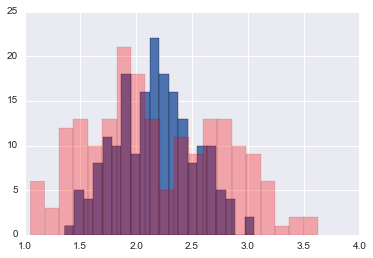

In [101]:
n_bins = 20
sns.plt.hist(preds, bins = n_bins)
sns.plt.hist(y_test, color = 'red', alpha = 0.3, bins = n_bins)

In [103]:
class_y15 = y15 > np.percentile(y15, 70)
X_train, X_test, y_train, y_test = train_test_split(X, class_y15)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [105]:
m = GPy.models.GPClassification(X_train, y_train[:,np.newaxis])

In [109]:
m.optimize()
m.optimize_restarts(30)

Optimization restart 1/30, f = 1049.22335849
Optimization restart 2/30, f = 1025.85048268
Optimization restart 3/30, f = 960.241338908
Optimization restart 4/30, f = 1125.98297183
Optimization restart 5/30, f = 992.230004393
Optimization restart 6/30, f = 1057.82778848
Optimization restart 7/30, f = 1182.20628547
Optimization restart 8/30, f = 1037.90586151
Optimization restart 9/30, f = 1031.20029479
Optimization restart 10/30, f = 1066.72974751
Optimization restart 11/30, f = 1101.85143324
Optimization restart 12/30, f = 1036.26225129
Optimization restart 13/30, f = 1104.26151143
Optimization restart 14/30, f = 1065.30107624
Optimization restart 15/30, f = 1046.48373604
Optimization restart 16/30, f = 1004.12794619
Optimization restart 17/30, f = 1206.24785443
Optimization restart 18/30, f = 1044.89645231
Optimization restart 19/30, f = 957.759839085
Optimization restart 20/30, f = 1131.43109838
Optimization restart 21/30, f = 982.657327301
Optimization restart 22/30, f = 1014.321301

In [114]:
preds, var = m.predict(X_test)

In [198]:
m = SVC()
m.fit(X_train, y_train)
preds = m.predict(X_test)

In [200]:
tp, fp, tn, fn = 36, 52, 89, 13

16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130.0 33.0
16.0 11.0 130

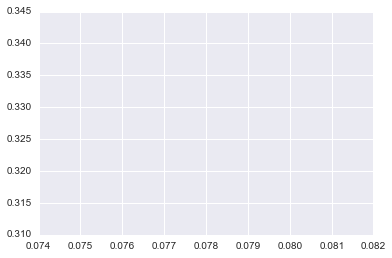

In [206]:
y_score = preds.flatten()
y_test = y_test.astype(int)

p1 = [0, 0, 0]
maps = np.array(p1)
for threshold in np.arange(0, 1.01, 0.01):
#     print "trying threshold ", threshold
    conv_pred = y_score > threshold
    
    num_pos = np.sum(conv_pred)
    print "num_pos: ", num_pos
    if num_pos > 0:
        num_TP = float(np.sum(y_test[conv_pred == 1]))
        num_FP = float(np.sum(1 - y_test[conv_pred] == 1))
        num_TN = float(np.sum(1 - y_test[conv_pred == 0]))
        num_FN = float(np.sum(y_test[conv_pred == 0]))
        print num_TP, num_FP, num_TN, num_FN
        tprate = num_TP / (num_TP + num_FN)
#         print "TPR: ", tprate
        fprate = num_FP / (num_FP + num_TN)
#         print "FPR: ", fprate
        maps = np.vstack((maps, [tprate, fprate, threshold]))
#     print "\n"
maps = maps[1:,:]
x, y = maps[:,1], maps[:, 0]
sns.plt.plot(x, y)